In [1]:
import sys
import os
import logging
import ast
import re
from tqdm.notebook import tqdm

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

In [3]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [4]:
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')

from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)

In [5]:
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')
    
    return

In [6]:
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
    return

In [7]:
def set_style(fsz=14):
    sns.set_context("paper")
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2
    
    return

In [79]:
wl_idx, N = 11, 1e7
table_zipf = dp.read_csv('new_exps/experiment_03_zipf_write_true.csv')
table_unif = dp.read_csv('vldb/exp_03_pt02.csv')

In [80]:
nominal_cols = ['nominal_z0_ms', 'nominal_z1_ms', 'nominal_q_ms', 'nominal_w_ms']
robust_cols = ['robust_z0_ms', 'robust_z1_ms', 'robust_q_ms', 'robust_w_ms']
workload_cols = ['z0_s', 'z1_s', 'q_s', 'w_s']

In [81]:
table_unif.workload_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [82]:
def get_query_response(table, wl_idx, num_keys, mode='nominal'):
    data = table.groupby(['workload_idx', 'N']).get_group((wl_idx, num_keys))
    z0_ms_query = (data[f'{mode}_z0_ms'] / (data['z0_s'] * data['num_queries'])).fillna(0).mean()
    z1_ms_query = (data[f'{mode}_z1_ms'] / (data['z1_s'] * data['num_queries'])).fillna(0).mean()
    q_ms_query = (data[f'{mode}_q_ms'] / (data['q_s'] * data['num_queries'])).fillna(0).mean()
    w_ms_query = (data[f'{mode}_w_ms'] / (data['w_s'] * data['num_queries'])).fillna(0).mean()
    query_response = {'z0': z0_ms_query,
                      'z1': z1_ms_query,
                      'q':  q_ms_query, 
                      'w':  w_ms_query}
    return query_response

In [83]:
qr_nom_zipf = get_query_response(table_zipf, wl_idx, N, mode='nominal')
qr_rob_zipf = get_query_response(table_zipf, wl_idx, N, mode='robust')
qr_nom_unif = get_query_response(table_unif, wl_idx, N, mode='nominal')
qr_rob_unif = get_query_response(table_unif, wl_idx, N, mode='robust')
qr_nom_zipf, qr_rob_zipf, qr_nom_unif, qr_rob_unif, qr_nom_zipf

({'z0': 0.0007510576437350959,
  'z1': 0.0010540117072640658,
  'q': 0.18171749780036342,
  'w': 0.1262505057816579},
 {'z0': 0.006341423646735807,
  'z1': 0.0063099092697840205,
  'q': 0.27649024562011704,
  'w': 0.010836228791909486},
 {'z0': 0.0011056250548683586,
  'z1': 0.08396519169818072,
  'q': 0.1851614850111023,
  'w': 0.11000774713187668},
 {'z0': 0.005763238384673655,
  'z1': 0.08446542685837971,
  'q': 0.25791638433021463,
  'w': 0.007032571724220021},
 {'z0': 0.0007510576437350959,
  'z1': 0.0010540117072640658,
  'q': 0.18171749780036342,
  'w': 0.1262505057816579})

In [84]:
data = (table_unif
      .groupby(['workload_idx', 'N'])
      .get_group((wl_idx, N)))
w0 = (data.iloc[0][['z0', 'z1', 'q', 'w']].values.tolist())
w_hat = (data[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values.tolist())

nom_policy = 'Leveling' if data.iloc[0].nominal_is_leveling_policy else 'Tiering'
robust_policy = 'Leveling' if data.iloc[0].robust_is_leveling_policy else 'Tiering'
nom_h = data.iloc[0].nominal_m_filt / data.iloc[0].N
nom_T = data.iloc[0].nominal_T
robust_h = data.iloc[0].robust_m_filt / data.iloc[0].N
robust_T = data.iloc[0].robust_T

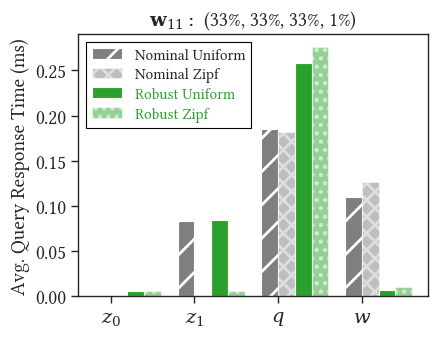

In [85]:
fig, ax = plt.subplots(tight_layout=True)
set_style()
index = np.arange(len(nominal_ms_query))
bar_width = 0.2
ax.bar(
    index,
    qr_nom_unif.values(),
    bar_width,
    color='tab:gray',
    hatch='/',
    label=f'Nominal Uniform')
ax.bar(
    index + bar_width,
    qr_nom_zipf.values(),
    bar_width,
    color='tab:gray',
    alpha=0.5,
    hatch='XX',
    label=f'Nominal Zipf')
ax.bar(
    index + (2 * bar_width),
    qr_rob_unif.values(),
    bar_width,
    color='tab:green',
    label=f'Robust Uniform')
ax.bar(
    index + (3 * bar_width),
    qr_rob_zipf.values(),
    bar_width,
    color='tab:green',
    alpha=0.5,
    hatch='..',
    label=f'Robust Zipf')
ax.set_xticks(index + bar_width / 2, ('$z_0$', '$z_1$', '$q$', '$w$'))
ax.set_ylabel('Avg. Query Response Time (ms)')
l = ax.legend(
    loc='upper left',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fancybox=False,
    labelspacing=0.3,
    fontsize=11)
ax.set_title(
    '$\mathbf{w}_{' \
    f'{wl_idx if wl_idx < 15 else ""}' + '}:\ $' \
    f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)')
l.get_texts()[-1].set_color('tab:green')
l.get_texts()[-2].set_color('tab:green')
set_size(fig, width=4.6, height=3.6)

In [205]:
save_fig(fig, f'query_times_w{wl_idx}.pdf')

In [206]:
table = pd.read_csv('/scratchNVM0/ndhuynh/data/exp_03_writes_vldb.csv')

In [207]:
query_response_nominal = get_query_response(table, 15, 1e7, mode='nominal')
query_response_robust = get_query_response(table, 15, 1e7, mode='robust')
query_response_default = get_query_response(table, 15, 1e7, mode='default')

data = (table
      .groupby(['workload_idx', 'N'])
      .get_group((15, 1e7)))
w0 = (data.iloc[0][['z0', 'z1', 'q', 'w']].values.tolist())
w_hat = (data[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values.tolist())

nom_policy = 'Leveling' if data.iloc[0].nominal_is_leveling_policy else 'Tiering'
robust_policy = 'Leveling' if data.iloc[0].robust_is_leveling_policy else 'Tiering'
nom_h = data.iloc[0].nominal_m_filt / data.iloc[0].N
nom_T = data.iloc[0].nominal_T
robust_h = data.iloc[0].robust_m_filt / data.iloc[0].N
robust_T = data.iloc[0].robust_T

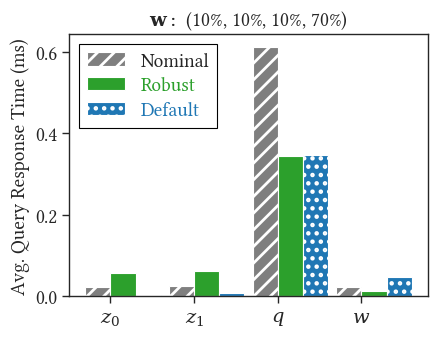

In [208]:
fig, ax = plt.subplots(tight_layout=True)
set_style()
index = np.arange(len(nominal_ms_query))
bar_width = 0.3
ax.bar(
    index,
    query_response_nominal.values(),
    bar_width,
    color='tab:gray',
    hatch='//',
    label=f'Nominal')
ax.bar(
    index + bar_width,
    query_response_robust.values(),
    bar_width,
    color='tab:green',
    label=f'Robust')
ax.bar(
    index + (2 * bar_width),
    query_response_default.values(),
    bar_width,
    hatch='..',
    color='tab:blue',
    label=f'Default')
ax.set_xticks(index + bar_width / 2, ('$z_0$', '$z_1$', '$q$', '$w$'))
ax.set_ylabel('Avg. Query Response Time (ms)')
l = ax.legend(
    loc='upper left',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fancybox=False,
    labelspacing=0.3,
    fontsize=14)
ax.set_title(
    '$\mathbf{w}:\ $' \
    f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)')
l.get_texts()[-1].set_color('tab:blue')
l.get_texts()[-2].set_color('tab:green')
set_size(fig, width=4.6, height=3.6)

In [209]:
save_fig(fig, f'query_times_default_w15.pdf')

In [188]:
table_def = pd.read_csv('/scratchNVM0/ndhuynh/data/exp_03_writes_default_direct_false.csv')
table_all = pd.read_csv('/scratchNVM0/ndhuynh/data/vldb/exp_03_pt02.csv')
default_cols = ['default_m_filt', 'default_m_buff', 'default_T', 'default_cost',
                'default_bpe', 'default_is_leveling_policy', 'default_l1_hit',
                'default_l2_plus_hit', 'default_z0_ms', 'default_z1_ms', 'default_q_ms',
                'default_w_ms', 'default_compact_ms', 'default_filter_neg',
                'default_filter_pos', 'default_filter_pos_true', 'default_bytes_written',
                'default_compact_read', 'default_compact_write', 'default_flush_written',
                'default_blocks_read', 'default_runs_per_level']

left = table_all[table_all.workload_idx == 11].reset_index(drop=True)
right = table_def[table_def.workload_idx == 11][default_cols].reset_index(drop=True)
df = pd.concat((left, right), axis=1)

In [189]:
df.to_csv('/scratchNVM0/ndhuynh/data/vldb/exp_03_wl11_writes.csv', index=False)

In [194]:
table_direct_off = pd.read_csv('/scratchNVM0/ndhuynh/data/new_exps/experiment_03_direct-reads-false-write-true.csv')
table_direct_on = pd.read_csv('/scratchNVM0/ndhuynh/data/vldb/exp_03_pt02.csv')

In [198]:
query_response_nominal_direct_on = get_query_response(table_direct_on, 11, 1e7, 'nominal')
query_response_robust_direct_on = get_query_response(table_direct_on, 11, 1e7, 'robust')
query_response_nominal_direct_off = get_query_response(table_direct_off, 11, 1e7, 'nominal')
query_response_robust_direct_off = get_query_response(table_direct_off, 11, 1e7, 'robust')

data = (table
      .groupby(['workload_idx', 'N'])
      .get_group((11, 1e7)))
w0 = (data.iloc[0][['z0', 'z1', 'q', 'w']].values.tolist())
w_hat = (data[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values.tolist())

nom_policy = 'Leveling' if data.iloc[0].nominal_is_leveling_policy else 'Tiering'
robust_policy = 'Leveling' if data.iloc[0].robust_is_leveling_policy else 'Tiering'
nom_h = data.iloc[0].nominal_m_filt / data.iloc[0].N
nom_T = data.iloc[0].nominal_T
robust_h = data.iloc[0].robust_m_filt / data.iloc[0].N
robust_T = data.iloc[0].robust_T

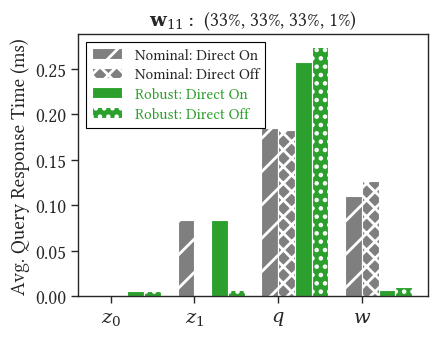

In [202]:
fig, ax = plt.subplots(tight_layout=True)
set_style()
index = np.arange(len(nominal_ms_query))
bar_width = 0.2
ax.bar(
    index,
    query_response_nominal_direct_on.values(),
    bar_width,
    color='tab:gray',
    hatch='/',
    label=f'Nominal: Direct On')
ax.bar(
    index + bar_width,
    query_response_nominal_direct_off.values(),
    bar_width,
    color='tab:gray',
    hatch='XX',
    label=f'Nominal: Direct Off')
ax.bar(
    index + 2 * bar_width,
    query_response_robust_direct_on.values(),
    bar_width,
    color='tab:green',
    label=f'Robust: Direct On')
ax.bar(
    index + 3 * bar_width,
    query_response_robust_direct_off.values(),
    bar_width,
    hatch='..',
    color='tab:green',
    label=f'Robust: Direct Off')
ax.set_xticks(index + bar_width / 2, ('$z_0$', '$z_1$', '$q$', '$w$'))
ax.set_ylabel('Avg. Query Response Time (ms)')
l = ax.legend(
    loc='upper left',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fancybox=False,
    labelspacing=0.3,
    fontsize=11)
ax.set_title(
    '$\mathbf{w}_{' \
    f'{wl_idx if wl_idx < 15 else ""}' + '}:\ $' \
    f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)')
l.get_texts()[-1].set_color('tab:green')
l.get_texts()[-2].set_color('tab:green')
set_size(fig, width=4.6, height=3.6)

In [203]:
save_fig(fig, f'direct_reads_on_off.pdf')